In [1]:
# Import modules

import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in data, process it so that player data and tracking can be merged
# Takes a few minutes

df_games = pd.read_csv('games.csv')
df_plays = pd.read_csv('plays.csv')
df_players = pd.read_csv('players.csv')
df_plays = df_plays.merge(df_games)
df_players.loc[len(df_players.index)] = [0, np.nan, np.nan, np.nan, np.nan, 'football', 'Football']
week = {}
for i in range(1, 18):
    week[i] = pd.read_csv('week' + str(i) + '.csv')
    week[i]['nflId'] = week[i]['nflId'].fillna(0.)
    week[i]['position'] = week[i]['position'].fillna('football')
    week[i] = week[i].merge(df_players, on=['nflId', 'displayName', 'position'])

In [3]:
# Include only "normal" completed passes (i.e. no fake FG/punt attempts),
#  where the receiver has YAC potential (i.e. not catching the ball in the endzone)
# Play action and RPOs are also filtered out in this analysis, to obtain a more consistent metric
# Takes a few minutes

# Valid plays must not contain any event in events_exclude
events_exclude = set(['field_goal_blocked', 'field_goal_fake', 'field_goal_play',
                      'fumble', 'fumble_defense_recovered', 'fumble_offense_recovered',
                      'handoff', 'lateral', 'pass_lateral', 'pass_shovel', 'pass_tipped',
                      'penalty_accepted', 'penalty_flag', 'play_action', 'punt_fake', 
                      'qb_sack', 'qb_spike', 'qb_strip_sack', 'run', 'run_pass_option',
                      'safety', 'snap_direct', 'timeout_home', 'touchback',
                      'pass_outcome_touchdown'])
# Valid plays must include all events in events_include
events_include = set(['ball_snap', 'pass_arrived', 'pass_forward', 'pass_outcome_caught'])
# Valid plays must include one of the events in events_include_either
events_include_either = set(['tackle', 'out_of_bounds', 'touchdown'])

# List of (gameId, playId) for all plays that include tackles, forced out of bounds, or receiver gets YAC TD
plays_tackle = []
for i in range(len(df_plays)):
    game_id = df_plays.iloc[i]['gameId']
    play_id = df_plays.iloc[i]['playId']
    week_num = df_plays.iloc[i]['week']
    events = set(week[week_num].loc[(week[week_num]['gameId']==game_id)&(week[week_num]['playId']==play_id)]['event'].unique())
    if len(events_exclude.intersection(events)) != 0:
        continue
    elif not events_include.issubset(events):
        continue
    elif 'tackle' in events or 'out_of_bounds' in events or 'touchdown' in events:
        plays_tackle.append((game_id, play_id))
    else:
        continue

In [4]:
# Function to find playerId of receiver on a play, given the play's tracking data
# Returns -1 for errors

def get_receiver(play):
    frame_pass_complete = play.loc[play['event']=='pass_outcome_caught']['frameId'].unique()[0]
    off_team = play.loc[play['position']=='QB']['team'].unique()[0]
    frame = play.loc[play['frameId']==frame_pass_complete]
    off_players = play.loc[play['team']==off_team]['nflId'].unique()
    football_x = frame.loc[frame['nflId']==0]['x'].unique()[0]
    football_y = frame.loc[frame['nflId']==0]['y'].unique()[0]
    min_dist = np.inf
    receiver = None
    for off_player in off_players:
        try:
            off_player_x = frame.loc[frame['nflId']==off_player]['x'].unique()[0]
            off_player_y = frame.loc[frame['nflId']==off_player]['y'].unique()[0]
        except:
            return -1
        dist = (football_x - off_player_x)**2 + (football_y - off_player_y)**2
        if dist < min_dist:
            min_dist = dist
            receiver = off_player
    return receiver        

In [5]:
# Function to find playerId of tackler on a play, given the play's tracking data
#  if TD (no player made tackle) returns -1
#  for various errors, returns values -2, -3, and -4 (these will be filtered out later)

def get_tackler(play):
    game_id = play['gameId'].unique()[0]
    play_id = play['playId'].unique()[0]
    if (game_id, play_id) not in plays_tackle:
        print('Error: play not in the dataset')
        return None
    events = play['event'].unique()
    if 'touchdown' in events:
        return -1
    elif 'tackle' in events:
        frame_num = play.loc[play['event']=='tackle']['frameId'].unique()[0]
    elif 'out_of_bounds' in events:
        frame_num = play.loc[play['event']=='out_of_bounds']['frameId'].unique()[0]
    frame = play.loc[play['frameId']==frame_num]
    
    # Need to have 'home', 'away', and 'football' for teams
    if len(play['team'].unique()) != 3:
        return -4
    off_team = play.loc[play['position']=='QB']['team'].unique()[0]
    def_players = play.loc[(play['team']!=off_team)&(play['team']!='football')]['nflId'].unique()
    football_x = frame.loc[frame['nflId']==0]['x'].unique()[0]
    football_y = frame.loc[frame['nflId']==0]['y'].unique()[0]
    min_dist = np.inf
    tackler = None
    for def_player in def_players:
        # Throw out plays of Tony Jefferson single game tracking data error
        if (def_player == 2540164) & (game_id == 2018092301):
            return -3
        try:
            def_player_x = frame.loc[frame['nflId']==def_player]['x'].unique()[0]
        except:
            return -3
        def_player_y = frame.loc[frame['nflId']==def_player]['y'].unique()[0]
        dist = (football_x - def_player_x)**2 + (football_y - def_player_y)**2
        if dist < min_dist:
            min_dist = dist
            tackler = def_player
    # Throw out plays where tackle made by defender not given in tracking data (usually DL)
    if min_dist > 2:
        return -2
    return tackler

In [6]:
# Create dataframe for all valid plays (completed passes followed by tackle/out of bounds/walk-in TD)
# Takes a few minutes

df_plays_tackle = pd.DataFrame(columns=['gameId', 'playId', 'tacklerId'])

for i in range(len(plays_tackle)):
    game_id = plays_tackle[i][0]
    play_id = plays_tackle[i][1]
    week_num = df_plays.loc[(df_plays['gameId']==game_id)&(df_plays['playId']==play_id)]['week'].unique()[0]
    play = week[week_num].loc[(week[week_num]['gameId']==game_id)&(week[week_num]['playId']==play_id)]
    tackler_id = get_tackler(play)
    df_plays_tackle.loc[len(df_plays_tackle)] = [game_id, play_id, tackler_id]

df_plays_tackle.head()

,gameId,playId,tacklerId
0,2.018091e+09,75.0,79848.0
1,2.018091e+09,190.0,2552689.0
2,2.018091e+09,320.0,2539653.0
3,2.018091e+09,949.0,-2.0
4,2.018091e+09,1037.0,2539653.0


In [7]:
# Filter out plays with errors

df_plays_tackle_filtered = df_plays_tackle.loc[df_plays_tackle['tacklerId']>=-1]
df_plays_tackle_filtered.head()

,gameId,playId,tacklerId
0,2.018091e+09,75.0,79848.0
1,2.018091e+09,190.0,2552689.0
2,2.018091e+09,320.0,2539653.0
4,2.018091e+09,1037.0,2539653.0
5,2.018091e+09,1202.0,2555162.0


In [8]:
# Returns dataframe containing nearest three defenders to the football at a given frame

def get_nearest_def(frame):
    game_id = frame['gameId'].unique()[0]
    play_id = frame['playId'].unique()[0]
    
    off_team = frame.loc[frame['position']=='QB']['team'].unique()[0]
    def_players = frame.loc[(frame['team']!=off_team)&(frame['team']!='football')]['nflId'].unique()
    df_temp = pd.DataFrame(columns=['def_playerId', 'dist'])
    football_x = frame.loc[frame['nflId']==0]['x'].unique()[0]
    football_y = frame.loc[frame['nflId']==0]['y'].unique()[0]    
    for def_player in def_players:
        def_player_x = frame.loc[frame['nflId']==def_player]['x'].unique()[0]
        def_player_y = frame.loc[frame['nflId']==def_player]['y'].unique()[0]
        dist = np.sqrt((football_x - def_player_x)**2 + (football_y - def_player_y)**2)
        df_temp.loc[len(df_temp)] = [def_player, dist]
    df_temp = df_temp.sort_values(['dist'], ascending=True)
    df_temp = df_temp.iloc[:3]
    return df_temp

In [9]:
# For nearest three defenders at time of catch, add column for playerId  
# Takes a few minutes

def1_id = []
def2_id = []
def3_id = []

for i in range(len(df_plays_tackle_filtered)):
    game_id = df_plays_tackle_filtered.iloc[i]['gameId']
    play_id = df_plays_tackle_filtered.iloc[i]['playId']
    week_num = df_plays.loc[(df_plays['gameId']==game_id) & (df_plays['playId']==play_id)]['week'].unique()[0]
    play = week[week_num].loc[(week[week_num]['gameId']==game_id)&(week[week_num]['playId']==play_id)]
    frame_catch = play.loc[play['event']=='pass_outcome_caught']['frameId'].unique()[0]
    frame = play.loc[play['frameId']==frame_catch]
    
    df_nearest_def = get_nearest_def(frame)
    
    def1 = df_nearest_def.iloc[0]['def_playerId']
    def1_id.append(def1)    
    def2 = df_nearest_def.iloc[1]['def_playerId']
    def2_id.append(def2)
    
    def3 = df_nearest_def.iloc[2]['def_playerId']
    def3_id.append(def3)

# Ignore the errors that show up
df_plays_tackle_filtered['def1_id'] = def1_id
df_plays_tackle_filtered['def2_id'] = def2_id
df_plays_tackle_filtered['def3_id'] = def3_id

# Reset index
df_plays_tackle_filtered.reset_index(drop=True, inplace=True)
df_plays_tackle_filtered.head()

C:\Users\ssbol\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ssbol\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ssbol\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

,gameId,playId,tacklerId,def1_id,def2_id,def3_id
0,2.018091e+09,75.0,79848.0,79848.0,2555383.0,2552315.0
1,2.018091e+09,190.0,2552689.0,2552689.0,2495613.0,2557958.0
2,2.018091e+09,320.0,2539653.0,2539653.0,2555543.0,2555255.0
3,2.018091e+09,1037.0,2539653.0,2539653.0,2555255.0,2555543.0
4,2.018091e+09,1202.0,2555162.0,2555162.0,2556445.0,2555543.0


In [10]:
# Create column 'def_tackler' for which player on the defense was the tackler
#  if nearest defender is tackler, def_tackler = 1
#  if second (or third) nearest defender is tackler, def_tackler = 2 (or 3)
#  if there was not a tackle (i.e. walk-in TD), def_tackler = -1
#  if another player (not one of the three nearest defenders) was the tackler, def_tackler = 0

def_tackler = []

for i in range(len(df_plays_tackle_filtered)):
    tackler = df_plays_tackle_filtered.iloc[i]['tacklerId']
    def1 = df_plays_tackle_filtered.iloc[i]['def1_id']
    def2 = df_plays_tackle_filtered.iloc[i]['def2_id']
    def3 = df_plays_tackle_filtered.iloc[i]['def3_id']
    if tackler == def1:
        def_tackler.append(1)
    elif tackler == def2:
        def_tackler.append(2)
    elif tackler == def3:
        def_tackler.append(3)
    elif tackler == -1:
        def_tackler.append(-1)
    else:
        def_tackler.append(0)

# Ignore the error
df_plays_tackle_filtered['def_tackler'] = def_tackler
df_plays_tackle_filtered.head()

C:\Users\ssbol\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,gameId,playId,tacklerId,def1_id,def2_id,def3_id,def_tackler
0,2.018091e+09,75.0,79848.0,79848.0,2555383.0,2552315.0,1
1,2.018091e+09,190.0,2552689.0,2552689.0,2495613.0,2557958.0,1
2,2.018091e+09,320.0,2539653.0,2539653.0,2555543.0,2555255.0,1
3,2.018091e+09,1037.0,2539653.0,2539653.0,2555255.0,2555543.0,1
4,2.018091e+09,1202.0,2555162.0,2555162.0,2556445.0,2555543.0,1


In [11]:
# Create columns 'yds_remaining' for number of yards between football (at time of catch) and end zone

yds_remaining = []

for i in range(len(df_plays_tackle_filtered)):
    game_id = df_plays_tackle_filtered.iloc[i]['gameId']
    play_id = df_plays_tackle_filtered.iloc[i]['playId']
    week_num = df_plays.loc[(df_plays['gameId']==game_id) & (df_plays['playId']==play_id)]['week'].unique()[0]
    play = week[week_num].loc[(week[week_num]['gameId']==game_id)&(week[week_num]['playId']==play_id)]
    frame_start = play.loc[play['event']=='ball_snap']['frameId'].unique()[0]
    is_offense_left = (play.loc[(play['frameId']==frame_start)&(play['position']=='QB')]['x'].unique()[0]) > (play.loc[(play['frameId']==frame_start)&(play['position']=='football')]['x'].unique()[0])
    
    frame_catch = play.loc[play['event']=='pass_outcome_caught']['frameId'].unique()[0]
    frame = play.loc[play['frameId']==frame_catch]
    football_x = frame.loc[frame['team']=='football']['x'].unique()[0]
    
    if is_offense_left:
        yds = football_x
    # If offense is driving towards the right, find distance from right end (x=120), instead of left end (x=0)
    else:
        yds = 120 - football_x
    
    # Adjustment for 10 yards of end zone
    yds -= 10
    
    yds_remaining.append(yds)

# Ignore error
df_plays_tackle_filtered['yds_remaining'] = yds_remaining
df_plays_tackle_filtered.head()

C:\Users\ssbol\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,gameId,playId,tacklerId,def1_id,def2_id,def3_id,def_tackler,yds_remaining
0,2.018091e+09,75.0,79848.0,79848.0,2555383.0,2552315.0,1,71.52
1,2.018091e+09,190.0,2552689.0,2552689.0,2495613.0,2557958.0,1,12.49
2,2.018091e+09,320.0,2539653.0,2539653.0,2555543.0,2555255.0,1,93.45
3,2.018091e+09,1037.0,2539653.0,2539653.0,2555255.0,2555543.0,1,46.92
4,2.018091e+09,1202.0,2555162.0,2555162.0,2556445.0,2555543.0,1,17.23


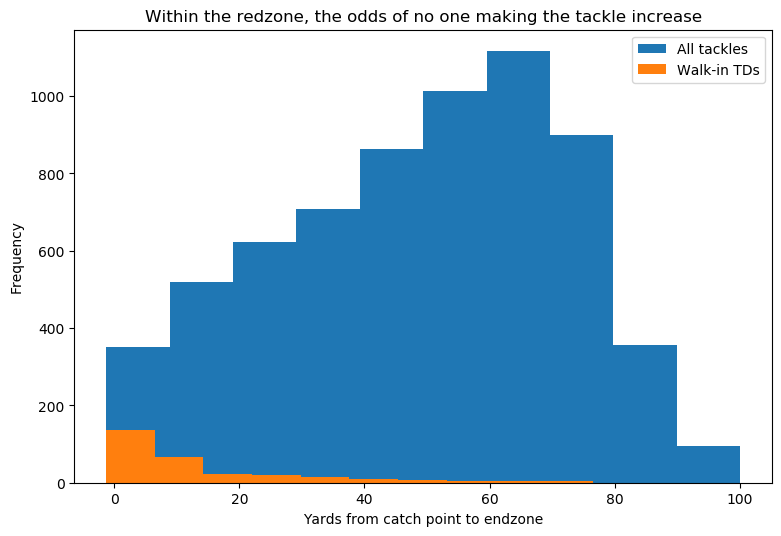

In [14]:
# To determine which defender is "responsible" for a tackle, we need to split up the field between inside/outside redzone.
# Within the redzone, the odds of no one making the tackle (i.e. walk-in TD) rise drastically. 
# Therefore, less "responsibility" should be expected of the defenders in this area.
 
plt.figure(figsize=(9,6), dpi=100)
plt.hist(df_plays_tackle_filtered['yds_remaining']);
plt.hist(df_plays_tackle_filtered.loc[df_plays_tackle_filtered['def_tackler']==-1]['yds_remaining']);
plt.xlabel('Yards from catch point to endzone')
plt.ylabel('Frequency')
plt.legend(['All tackles','Walk-in TDs'])
plt.title("Within the redzone, the odds of no one making the tackle increase");

In [13]:
# Create dataframe 'exp_tackles_values' to store the expected responsibility for a tackle 
#  Depends on inside/outside redzone, and whether defender is nearest, 2nd nearest, 3rd nearest, etc.

exp_tackles_values = pd.DataFrame(columns=['def_tackler', 'RZ', 'outside_RZ'])
in_RZ_num = len(df_plays_tackle_filtered.loc[df_plays_tackle_filtered['yds_remaining']<=20])
out_RZ_num = len(df_plays_tackle_filtered.loc[df_plays_tackle_filtered['yds_remaining']>20])
for tackler in [1, 2, 3, 0, -1]:
    in_RZ = len(df_plays_tackle_filtered.loc[(df_plays_tackle_filtered['yds_remaining']<=20)&(df_plays_tackle_filtered['def_tackler']==tackler)]) / in_RZ_num
    out_RZ = len(df_plays_tackle_filtered.loc[(df_plays_tackle_filtered['yds_remaining']>20)&(df_plays_tackle_filtered['def_tackler']==tackler)]) / out_RZ_num
    exp_tackles_values.loc[len(exp_tackles_values)] = [tackler, in_RZ, out_RZ]
exp_tackles_values

,def_tackler,RZ,outside_RZ
0,1.0,0.488017,0.563611
1,2.0,0.168845,0.216951
2,3.0,0.059913,0.093284
3,0.0,0.041394,0.113717
4,-1.0,0.241830,0.012438


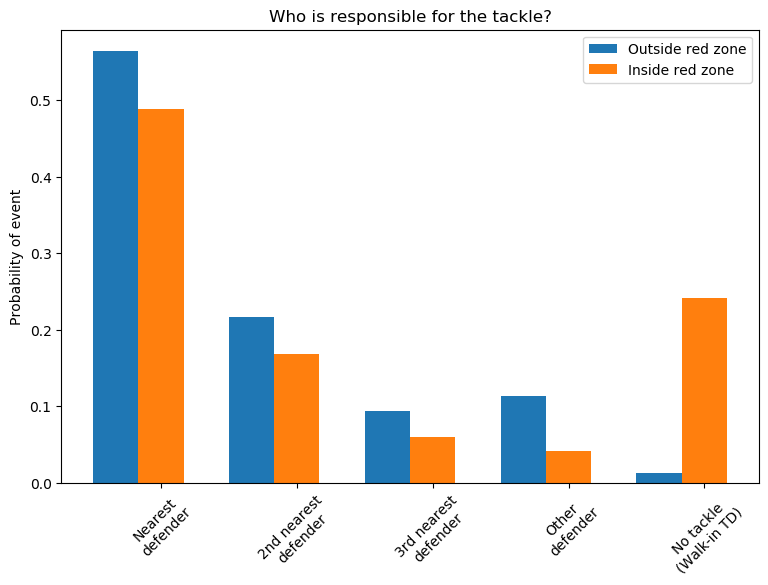

In [15]:
# Who is responsible for the tackle?

plt.figure(figsize=(9,6), dpi=100)
label = ['Nearest\ndefender', '2nd nearest\ndefender', '3rd nearest\ndefender', 'Other\ndefender', 'No tackle\n(Walk-in TD)']
plt.bar(3*np.arange(len(exp_tackles_values['def_tackler'])), exp_tackles_values['outside_RZ'], width=1, tick_label=label);
plt.bar(3*np.arange(len(exp_tackles_values['def_tackler']))+1, exp_tackles_values['RZ'], width=1, tick_label=label);
plt.xticks(rotation=45);
plt.legend(['Outside red zone', 'Inside red zone']);
plt.ylabel('Probability of event')
plt.title('Who is responsible for the tackle?');
plt.savefig('tackle_responsibilities.png')

In [16]:
# Create mapping from tacklerId to expected tackles ('exp_tackles')
#  If the defender was not one of the three nearest, split the expected responsibility between the rest of the defenders.
#  i.e. 'exp_other_rz' is the expected probability of a defender (not one of the three nearest) making the tackle. 
#        This responsibility should be split between those defenders. 
# Create mapping from tacklerId to number of plays they were involved in ('num_plays')
# Takes a few minutes

# within 20 ydline: 
exp_def1_rz = exp_tackles_values.loc[exp_tackles_values['def_tackler']==1]['RZ'].unique()[0]
exp_def2_rz = exp_tackles_values.loc[exp_tackles_values['def_tackler']==2]['RZ'].unique()[0]
exp_def3_rz = exp_tackles_values.loc[exp_tackles_values['def_tackler']==3]['RZ'].unique()[0]
exp_other_rz = exp_tackles_values.loc[exp_tackles_values['def_tackler']==0]['RZ'].unique()[0]

# outside 20 ydline:
exp_def1_outside_RZ = exp_tackles_values.loc[exp_tackles_values['def_tackler']==1]['outside_RZ'].unique()[0]
exp_def2_outside_RZ = exp_tackles_values.loc[exp_tackles_values['def_tackler']==2]['outside_RZ'].unique()[0]
exp_def3_outside_RZ = exp_tackles_values.loc[exp_tackles_values['def_tackler']==3]['outside_RZ'].unique()[0]
exp_other_outside_RZ = exp_tackles_values.loc[exp_tackles_values['def_tackler']==0]['outside_RZ'].unique()[0]

exp_tackles = {}
num_plays = {}

for i in range(len(df_plays_tackle_filtered)):
    game_id = df_plays_tackle_filtered.iloc[i]['gameId']
    play_id = df_plays_tackle_filtered.iloc[i]['playId']
    def1 = df_plays_tackle_filtered.iloc[i]['def1_id']
    def2 = df_plays_tackle_filtered.iloc[i]['def2_id']
    def3 = df_plays_tackle_filtered.iloc[i]['def3_id']
    ydline = df_plays_tackle_filtered.iloc[i]['yds_remaining']
    
    week_num = df_plays.loc[(df_plays['gameId']==game_id)&(df_plays['playId']==play_id)]['week'].unique()[0]
    play = week[week_num].loc[(week[week_num]['gameId']==game_id)&(week[week_num]['playId']==play_id)]
    
    off_team = play.loc[play['position']=='QB']['team'].unique()[0]
    def_players = play.loc[(play['team']!=off_team)&(play['team']!='football')]['nflId'].unique()
    
    df_temp = pd.DataFrame(columns=['def_playerId', 'dist'])
    
    frame_catch = play.loc[play['event']=='pass_outcome_caught']['frameId'].unique()[0]
    frame = play.loc[play['frameId']==frame_catch]
    football_x = frame.loc[frame['nflId']==0]['x'].unique()[0]
    football_y = frame.loc[frame['nflId']==0]['y'].unique()[0]
    
    # To divide the tackle responsibility between the rest of the defenders (not closest three)
    n = len(def_players) - 3
    
    for def_player in def_players:
        if exp_tackles.get(def_player, None) == None:
            exp_tackles[def_player] = 0
            num_plays[def_player] = 0
        if ydline <= 20:
            if def_player == def1:
                exp_tackles[def_player] += exp_def1_rz
            elif def_player == def2:
                exp_tackles[def_player] += exp_def2_rz
            elif def_player == def3:
                exp_tackles[def_player] += exp_def3_rz
            else:
                exp_tackles[def_player] += exp_other_rz / n
        else:
            if def_player == def1:
                exp_tackles[def_player] += exp_def1_outside_RZ
            elif def_player == def2:
                exp_tackles[def_player] += exp_def2_outside_RZ
            elif def_player == def3:
                exp_tackles[def_player] += exp_def3_outside_RZ
            else:
                exp_tackles[def_player] += exp_other_outside_RZ / n 
        num_plays[def_player] += 1

In [17]:
# Create dataframe of actual tackle count by tacklerId

actual_tackles = df_plays_tackle_filtered.groupby(['tacklerId'], as_index=False).gameId.agg('count')
actual_tackles.columns = ['tacklerId', 'num_plays']
actual_tackles.head()

,tacklerId,num_plays
0,-1.0,292
1,1302.0,10
2,2307.0,28
3,2354.0,25
4,4365.0,18


In [18]:
# Create dataframe of tackles over expected

df_tackles_over_exp = pd.DataFrame(columns=['tacklerId', 'name', 'exp_tackles', 'tackles', 'tackles_over_exp', 'num_plays', 'toe_per_play'])

for tackler in actual_tackles['tacklerId'].unique():
    
    # Corresponds to no one making the tackle ('walk-in TD')
    if tackler == -1:
        continue
    
    exp = exp_tackles[tackler]
    name = df_players.loc[df_players['nflId']==tackler]['displayName'].unique()[0]
    tackles = actual_tackles.loc[actual_tackles['tacklerId']==tackler]['num_plays'].unique()[0]
    tackles_over_exp = tackles - exp
    num = num_plays[tackler]
    toe_per_play = tackles_over_exp / num
    df_tackles_over_exp.loc[len(df_tackles_over_exp)] = [tackler, name, exp, tackles, tackles_over_exp, num, toe_per_play]

df_tackles_over_exp = df_tackles_over_exp.sort_values('toe_per_play', ascending=False)
df_tackles_over_exp.head()

,tacklerId,name,exp_tackles,tackles,tackles_over_exp,num_plays,toe_per_play
408,2559043.0,Chase Allen,0.216951,1,0.783049,1,0.783049
386,2558185.0,Tanoh Kpassagnon,0.216951,1,0.783049,1,0.783049
196,2550767.0,C.J. Goodwin,0.488017,1,0.511983,1,0.511983
407,2559037.0,Ahmad Thomas,0.471808,2,1.528192,3,0.509397
416,2559200.0,Joe Jones,1.090796,3,1.909204,4,0.477301
